# Metrics

In [1]:
import sys
sys.path.append('..')
from utils.utils import *
%load_ext autoreload
%autoreload 2

In [2]:
cfg = {
'EXPERIMENT': 'filter20_',
'DATASET': 'sa1b',
'MODEL': 'MobileSAM_iou_bce_sigm',
'TARGET': 'SAM',
'SPARSITY': 0,
'CLASS': 0,
'MODE': '',
'METRIC': 'iou'
}
cfg['ROOT'], cfg['N'], cfg['CLASSES'], cfg['SUPERCLASSES'], cfg['SUP_N'] = get_dataset_info(cfg['DATASET'])
cfg['SUP_L'] = {v: k for k, v in cfg['SUP_N'].items()}

## Compute Metrics

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df_p = pd.read_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_prompts.pkl")
df_0 = pd.read_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['TARGET']}_0.pkl")
df_s = pd.read_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")

In [36]:
df_p.head()

,name,prompt,class,image_shape,shape,mask,mask_origin,score,s_class,mask_size
0,sa_231941,"[70, 480]",None,"(2250, 3)","(1500, 2250)","[[True, True, False, False, False, False, Fals...","[372, 0]",0,None,0.006076
1,sa_234721,"[74, 1272]",None,"(2247, 3)","(1500, 2247)","[[False, False, False, False, False, False, Fa...","[1153, 0]",0,None,0.005900
2,sa_234928,"[1015, 932]",None,"(1500, 3)","(2250, 1500)","[[False, False, False, False, False, False, Fa...","[746, 880]",0,None,0.006964
3,sa_227443,"[2112, 902]",None,"(2250, 3)","(1500, 2250)","[[False, False, False, False, False, False, Fa...","[890, 2090]",0,None,0.001059
4,sa_231190,"[2056, 415]",None,"(2250, 3)","(1500, 2250)","[[False, False, False, False, False, False, Fa...","[316, 2034]",0,None,0.001991


In [6]:
df_p['score'] = df_p.apply(lambda x: 0, axis=1)
df_p['s_class'] = df_p.apply(lambda x: None, axis=1)

In [44]:
def get_mask_size(s, df=None):
    if df is not None:
        imsize = df[df['name']==s['name']]['shape'].values[0]
    else:
        imsize = s['shape']
    return np.sum(s['mask']) / (imsize[0] * imsize[1])

In [15]:
df_p['mask_size'] = df_p.apply(get_mask_size, axis=1)

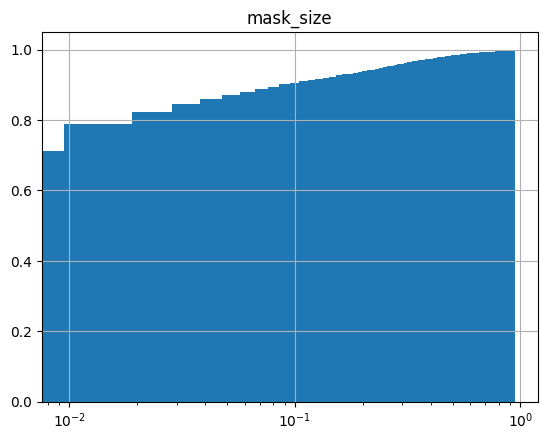

In [29]:
df_p.hist(column='mask_size', bins=100, cumulative=True, density=True)
plt.semilogx()
plt.show()

In [55]:
for p in range(0, 110, 10):
    print(f'{p}\t{np.percentile(df_p["mask_size"], p):.1e}')

0	0.0e+00
10	4.8e-04
20	7.9e-04
30	1.2e-03
40	1.9e-03
50	3.0e-03
60	4.8e-03
70	8.7e-03
80	2.2e-02
90	9.3e-02
100	9.5e-01


In [43]:
df_0['mask_size'] = df_0.apply(lambda s: get_mask_size(s, df_p), axis=1)

(1500, 2250)
(1500, 2247)
(2250, 1500)
(1500, 2250)
(1500, 2250)
(1500, 2250)
(1500, 2240)
(1500, 2250)
(2664, 1500)
(1500, 2250)
(2250, 1500)
(1500, 2258)
(1500, 2250)
(1500, 2250)
(2000, 1500)
(1500, 2667)
(1500, 2250)
(1500, 2250)
(2250, 1500)
(2250, 1500)
(2241, 1500)
(2000, 1500)
(1500, 2248)
(1500, 2250)
(1500, 2275)
(1500, 2250)
(1500, 2250)
(1500, 2000)
(1500, 2254)
(2250, 1500)
(2241, 1500)
(1500, 2250)
(1500, 2250)
(1856, 1500)
(2282, 1500)
(1500, 2249)
(1500, 2000)
(1500, 2265)
(2000, 1500)
(1500, 2250)
(1500, 2247)
(1500, 2250)
(2241, 1500)
(1500, 2264)
(2250, 1500)
(1500, 2000)
(1500, 2250)
(1500, 2250)
(1500, 2250)
(1500, 2218)
(1500, 2667)
(1500, 2219)
(1500, 2256)
(1500, 2250)
(1500, 2250)
(2250, 1500)
(1500, 2247)
(1500, 2250)
(1500, 1500)
(2183, 1500)
(1500, 2250)
(1500, 2000)
(2000, 1500)
(1500, 2000)
(1500, 2250)
(1500, 2010)
(1500, 2241)
(1500, 3220)
(1500, 2250)
(1500, 2250)
(2250, 1500)
(1500, 2259)
(1500, 2250)
(1500, 2250)
(1500, 2250)
(1500, 2250)
(1500, 2249)

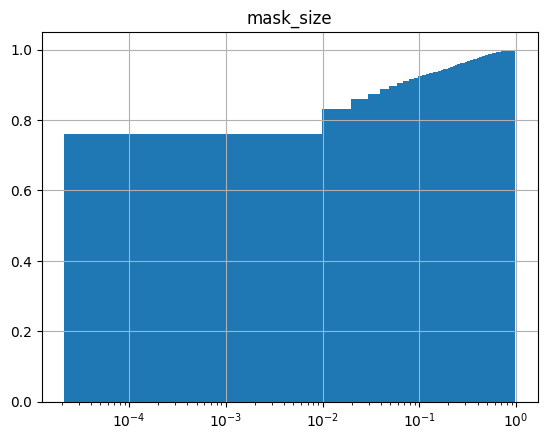

In [45]:
df_0.hist(column='mask_size', bins=100, cumulative=True, density=True)
plt.semilogx()
plt.show()

In [8]:
df_0.head()

,name,prompt,class,s_class,mask,mask_origin,score
0,sa_231941,"[70, 480]",None,None,"[[True, True, True, False, False, False, False...","[373, 0]",0.879714
1,sa_234721,"[74, 1272]",None,None,"[[False, False, False, False, False, False, Fa...","[1158, 0]",0.969980
2,sa_234928,"[1015, 932]",None,None,"[[False, False, False, False, False, False, Fa...","[740, 880]",0.979988
3,sa_227443,"[2112, 902]",None,None,"[[False, False, False, False, False, False, Fa...","[890, 2090]",0.874941
4,sa_231190,"[2056, 415]",None,None,"[[False, False, False, False, False, False, Fa...","[317, 2035]",0.938597


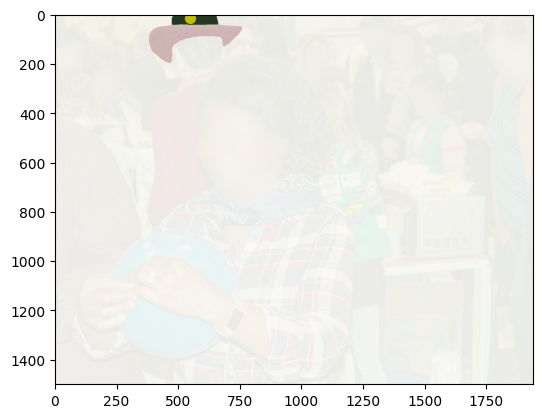

In [9]:
i = 900
plt.imshow(get_image(df_p['name'][i], cfg))
plt.scatter(*df_p['prompt'][i], c='y', s=50)
plt.imshow(get_full_mask(df_s['mask'][i], df_s['mask_origin'][i], df_p['shape'][i]), alpha=0.6, cmap='Blues')
plt.imshow(get_full_mask(df_0['mask'][i], df_0['mask_origin'][i], df_p['shape'][i]), alpha=0.6, cmap='Reds')
plt.imshow(get_full_mask(df_p['mask'][i], df_p['mask_origin'][i], df_p['shape'][i]), alpha=0.6, cmap='Greens')
plt.show()

In [10]:
# Add Image Shape
if 'shape' not in df_p.keys():
    df_p = add_image_shape(df_p, cfg)
    df_p.head()
    df_p.to_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_prompts.pkl")

In [10]:
# GT vs SAM
df_g0 = get_analytics(df_p, df_0, df_p, cfg, skip_empty=True)
df_g0.to_pickle(f"../results/analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['TARGET']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")
df_g0.head()

,name,prompt,class,t_class,s_class,score,score_diff,mask_size,mask_size_diff,iou,pixel_acc,dice,precision,recall,specificity
0,sa_231941,"[70, 480]",None,None,None,0.879714,87971.436977,0.596296,0.025372,0.984323,0.999904,0.992100,0.995191,0.989028,0.999971
1,sa_234721,"[74, 1272]",None,None,None,0.969980,96998.000145,0.731435,0.024438,0.964898,0.999791,0.982136,0.991292,0.973147,0.999949
2,sa_234928,"[1015, 932]",None,None,None,0.979988,97998.797894,0.695565,-0.023382,0.984190,0.999889,0.992032,0.988262,0.995830,0.999917
3,sa_227443,"[2112, 902]",None,None,None,0.874941,87494.075298,0.445017,0.383554,0.761866,0.999743,0.864840,0.974728,0.777218,0.999979
4,sa_231190,"[2056, 415]",None,None,None,0.938597,93859.660625,0.683460,0.066221,0.941877,0.999880,0.970069,0.963730,0.976492,0.999927


In [ ]:
#df_g0 = pd.read_pickle(f"../results/analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['TARGET']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")

In [11]:
# GT vs MobileSAM
df_gs = get_analytics(df_p, df_s, df_p, cfg, skip_empty=True)
df_gs.to_pickle(f"../results/analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")
df_gs.head()

,name,prompt,class,t_class,s_class,score,score_diff,mask_size,mask_size_diff,iou,pixel_acc,dice,precision,recall,specificity
0,sa_231941,"[70, 480]",None,None,None,0.927230,92723.011971,0.561102,-0.035044,0.952063,0.999704,0.975443,0.983445,0.967570,0.999900
1,sa_234721,"[74, 1272]",None,None,None,0.912135,91213.512421,0.723970,0.013997,0.914638,0.999485,0.955416,0.976328,0.935382,0.999865
2,sa_234928,"[1015, 932]",None,None,None,0.915822,91582.208872,0.460901,-0.352392,0.536450,0.996765,0.698298,0.996137,0.537568,0.999985
3,sa_227443,"[2112, 902]",None,None,None,0.808789,80878.937244,0.488613,0.518788,0.423247,0.999344,0.594763,0.860169,0.454520,0.999922
4,sa_231190,"[2056, 415]",None,None,None,0.826633,82663.309574,0.676971,0.056112,0.831315,0.999645,0.907889,0.939379,0.878441,0.999887


In [12]:
len(df_p) - len(df_gs)

68

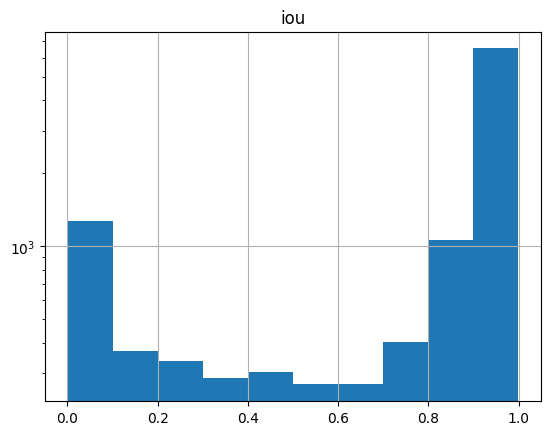

0.7396803597758249

In [60]:
# SAM
df_g0.hist(column='iou')
plt.semilogy()
plt.show()
df_g0['iou'].mean()

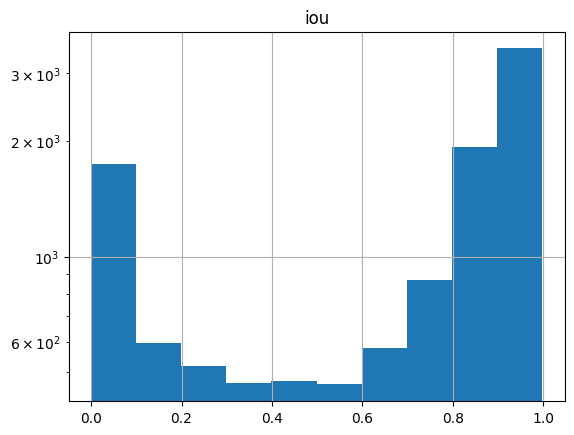

0.6176237923929842

In [58]:
# Mobile
df_gs.hist(column='iou')
plt.semilogy()
plt.show()
df_gs['iou'].mean()

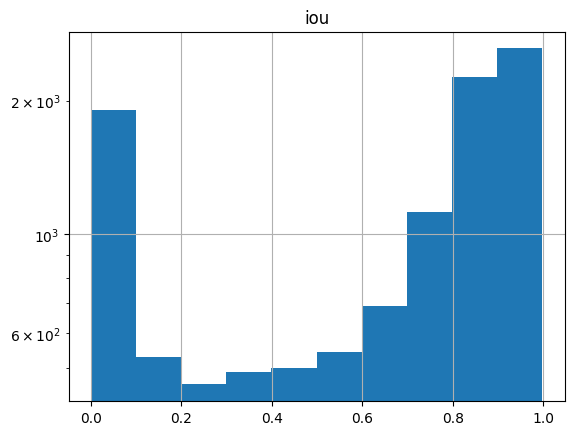

0.5961169938621866

In [13]:
# IoU_BCE
df_gs.hist(column='iou')
plt.semilogy()
plt.show()
df_gs['iou'].mean()

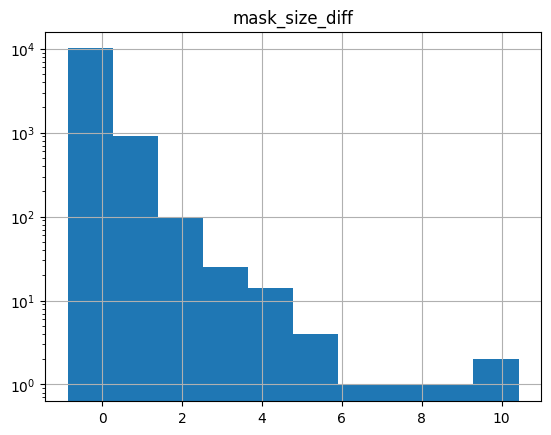

0.053572255092544055

In [61]:
# SAM
df_g0.hist(column='mask_size_diff')
plt.semilogy()
plt.show()
df_g0['mask_size_diff'].mean()

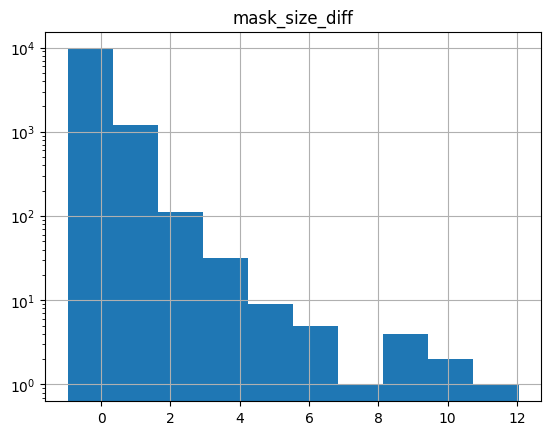

0.10892205845409302

In [59]:
# Mobile
df_gs.hist(column='mask_size_diff')
plt.semilogy()
plt.show()
df_gs['mask_size_diff'].mean()

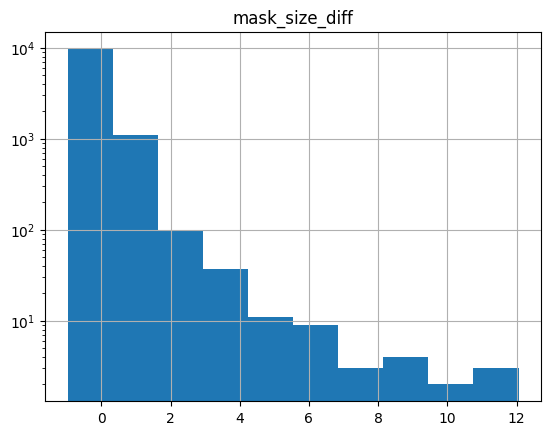

0.06278725974815419

In [14]:
# IOU_BCE
df_gs.hist(column='mask_size_diff')
plt.semilogy()
plt.show()
df_gs['mask_size_diff'].mean()

## Batch Save Analytics

In [ ]:
save_analytics(cfg)

In [ ]:
get_summary(cfg)

In [ ]:
get_summary(cfg)

In [ ]:
# for s in range(10, 100, 10):
#     cfg['SPARSITY'] = s
#     save_analytics(cfg)

## Global Analytics

In [ ]:
# Save Summary
summary = []
for m in MODES:
    cfg['MODE'] = m
    for s in SPARSITIES:
        cfg['SPARSITY'] = s
        summary.append(get_summary(cfg))

cfg['MODE'] = ''
cfg['SPARSITY'] = 0
for n in MODELS[1:]:
    cfg['MODEL'] = n
    summary.append(get_summary(cfg))
summary = pd.concat(summary)
summary.to_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_summary.pkl")

In [ ]:
# Histograms
for t in METRICS:
    cfg['METRIC'] = t
    for m in MODES:
        cfg['MODE'] = m
        summary = []
        for s in SPARSITIES:
            cfg['SPARSITY'] = s
            summary.append(get_summary(cfg))
        summary = pd.concat(summary)
        get_hists(summary, cfg, save=True, plot=True)
plt.clf()

In [ ]:
cfg['MODE'] = ''
cfg['SPARSITY'] = 0
for t in METRICS:
    cfg['METRIC'] = t
    summary = []
    for n in MODELS[1:]:
        cfg['MODEL'] = n
        summary.append(get_summary(cfg))
    summary = pd.concat(summary)
    get_hists(summary, cfg, save=True, plot=True)
    plt.clf()

## Global Curves

In [ ]:
summary = pd.read_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_summary.pkl")

for m in METRICS:
    cfg['METRIC'] = m
    get_curves(summary, cfg, std=False, plot=True, save=True)

## Class-wise Analytics

In [ ]:
# Save Summary
summary = []
for m in MODES:
    cfg['MODE'] = m
    for s in SPARSITIES:
        cfg['SPARSITY'] = s
        summary.append(get_summary(cfg, classwise=True))

cfg['MODE'] = ''
cfg['SPARSITY'] = 0
for n in MODELS[1:]:
    cfg['MODEL'] = n
    summary.append(get_summary(cfg, classwise=True))
summary = pd.concat(summary)
summary.to_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_classwise.pkl")

In [ ]:
d = summary[summary['pruning']=='_gup']
d = d[d['id']==50]
d = d[d['class']!=0]
get_hists(d, cfg, save=False, plot=True)

## Class-wise Curves

In [ ]:
summary = pd.read_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_classwise.pkl")

In [ ]:
def get_classwise_curves(d, cfg, plot=True, save=False):
    _, ax = plt.subplots()
    ax.grid()
    ax.title.set_text(cfg['METRIC'].replace('_', ' ').capitalize())
    ax.plot(PARAMS['SAM'], SAM[cfg['METRIC']], 'o')
     
    for c in range(1, d.shape[1]):
        if cfg['MODEL'] == 'SAM':
            p = (1 - d[:,c,1]/100) * PARAMS['SAM'] 
        else:
            p = PARAMS[d[:,c,1][0]]
        ax.plot(p, d[:,c,2], '-o', label=f"{cfg['SUP_L'][c]} ({d[0,c,3]})")
    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=4, fontsize=9)   
    #plt.legend(loc='best', fontsize=9, ncol=2)
    plt.xlabel('Parameters')
    plt.ylabel(cfg['METRIC'].replace('_', ' ').capitalize())
    plt.axvline(PARAMS['SAM'], linestyle='--')
    plt.axhline(SAM[cfg['METRIC']], linestyle='--')
    plt.semilogx()
    if save:
        plt.savefig(f"figures/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['METRIC']}_{cfg['MODEL']}{cfg['MODE']}_curves_classwise.pdf", bbox_inches='tight')
    if plot:
        plt.show()
    plt.clf()

In [ ]:
# GUP
for m in METRICS:
    cfg['METRIC'] = m
    d = summary[summary['pruning']=='_gup'][['class', 'id', cfg['METRIC'], 'n']].values.reshape(9, 13, -1)
    get_classwise_curves(d, cfg, plot=True, save=True)

# SparseGPT
cfg['MODE'] = '_gup'
for m in METRICS:
    cfg['METRIC'] = m
    d = summary[summary['id'].str.isalpha().isnull()]
    d = d[d['pruning']!='_gup'][['class', 'id', cfg['METRIC'], 'n']].values.reshape(9, 13, -1)
    get_classwise_curves(d, cfg, plot=True, save=True)

# FastSAM
# cfg['MODEL'] = 'FastSAM'
# for m in METRICS:
#     cfg['METRIC'] = m
#     d = summary[summary['id']==cfg['MODEL']][['class', 'id', cfg['METRIC'], 'n']].values.reshape(1, 13, -1)
#     get_classwise_curves(d, cfg, plot=True, save=True)

# MobileSAM
# cfg['MODEL'] = 'MobileSAM'
# for m in METRICS:
#     cfg['METRIC'] = m
#     d = summary[summary['id']==cfg['MODEL']][['class', 'id', cfg['METRIC'], 'n']].values.reshape(1, 13, -1)
#     get_classwise_curves(d, cfg, plot=True, save=True)

# Mobile&FastSAM
cfg['MODEL'] = 'Mobile&FastSAM'
for m in METRICS:
    cfg['METRIC'] = m
    d = summary[summary['id'].str.isalpha().notnull()][['class', 'id', cfg['METRIC'], 'n']].values.reshape(1, 13, -1)
    get_classwise_curves(d, cfg, plot=True, save=True)

In [ ]:
def get_forgettability_curve_dissimilarity(d, cfg, plot=True, save=False):
    fcd = np.zeros((d.shape[1], d.shape[1]))
    for c1 in range(d.shape[1]):
        for c2 in range(c1, d.shape[1]):
            if c1 == c2:
                continue
            fcd[c1, c2] = ((d[:,c1,2] - d[:,c2,2])**2).mean()
            fcd[c2, c1] = fcd[c1, c2]

    plt.imshow(fcd, interpolation='nearest')
    plt.xticks(range(12), [cfg['SUP_L'][i] for i in range(1, 13)], rotation=90)
    plt.yticks(range(12), [cfg['SUP_L'][i] for i in range(1, 13)])
    plt.title('Forgettability Curve Dissimilarity - GUP')
    plt.colorbar()
    if save:
        plt.savefig(f"figures/{cfg['EXPERIMENT']}{cfg['DATASET']}{cfg['MODE']}_fcd.pdf", bbox_inches='tight')
    if plot:
        plt.show()
    else:
        plt.clf()


In [ ]:
if cfg['MODE'] == '':
    # SparseGPT
    d = summary[summary['id'].str.isalpha().isnull()]
    d = d[d['pruning']!='_gup'][['class', 'id', cfg['METRIC'], 'n']].values.reshape(9, 13, -1)[:,1:,:]
elif cfg['MODE'] == '_gup':
    # GUP
    d = summary[summary['pruning']=='_gup'][['class', 'id', cfg['METRIC']]].values.reshape(9, 13, -1)[:,1:,:]

In [ ]:
get_forgettability_curve_dissimilarity(d, cfg, plot=True, save=True)

## Cluster Analytics

In [ ]:
df = pd.read_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")
df.head()

In [ ]:
df.hist(column='iou')
plt.semilogy()
plt.show()

In [ ]:
df = add_superclass(df, cfg)
df['mask_size_target'] = (df['mask_size'] - df['mask_size_diff'] * 1e-5) / (1 + df['mask_size_diff'])
df['f1'] = 2 * df['precision'] * df['recall'] / (df['precision'] + df['recall'])

In [ ]:
features = ['iou', 'precision', 'recall', 'mask_size', 'mask_size_diff', 'superclass']
data = df[features].values

In [ ]:
df['cluster'] = get_clusters(data, cfg, plot=True, save=False)
#df.to_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")

In [ ]:
from itertools import product
def prod(l1, l2):
   return list(product(l1, l2))

M = ['iou', 'precision', 'recall']

fig, axs = plt.subplots(3, 3, sharex=True, sharey='row', figsize=(10,8))
for (ax, (c,m)) in zip(axs.flat, prod(range(3), M)):
    y, x = np.histogram(df[df['cluster']==c][m])
    ax.bar(x[:-1], y, width=x[1]-x[0], alpha=1)
    ax.set_title(f"[{c}] {m}", fontsize=10)
    ax.semilogy()
plt.suptitle(f"{cfg['MODEL']} {cfg['MODE']}", fontsize=12)
plt.savefig(f"figures/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}_clusters.pdf", bbox_inches='tight')
plt.show()

## CIEs

 **ID**       |**0**|**1**|**2**|
--------------|-----|-----|-----|
*SAM_40gup_20*|R    |IoU  |P    |
*SAM_80_20*   |P    |R    |IoU  |
*MobileSAM_20*|IoU  |R    |P    |
*FastSAM_20*  |R    |IoU  |P    |

In [ ]:
df = pd.read_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")
df_0 = pd.read_pickle(f"results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['TARGET']}_0.pkl")
df_s = pd.read_pickle(f"results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")

In [ ]:
C = 2
N = int(0.05*len(df))
df_c = df[df['cluster']==C]
min_iou = df_c.nsmallest(N, ['iou'])

In [ ]:
df_c['iou'].mean(), min_iou['iou'].mean()

In [ ]:
show_samples(pie_df=min_iou, target_df=df_0, pred_df=df_s, cfg=cfg, prompt_zoom=False, n=5, random=True, save=False)

## Small Masks

In [ ]:
df = pd.read_pickle(f"../results/analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")
df_0 = pd.read_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['TARGET']}_0.pkl")
df_s = pd.read_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")

In [ ]:
# Filter out SAM's wrong masks (out of prompt)
df_0['check'] = df_0.apply(lambda s: check_prompt(s), axis=1)
df_0.hist(column='check', range=(0,.1))

df_0 = df_0[df_0['check']!=0]
df = df[(df.name.isin(df_0.name))]
df_s = df_s[(df_s.name.isin(df_0.name))]

In [ ]:
df_s['check'] = df_s.apply(lambda s: check_prompt(s), axis=1)
df_s.hist(column='check', range=(0,.1))

df_s = df_s[df_s['check']!=0]
df = df[(df.name.isin(df_s.name))]
df_0 = df_0[(df_0.name.isin(df_s.name))]

In [ ]:
df['mask_size_target'] = (df['mask_size'] - df['mask_size_diff'] * 1e-5) / (1 + df['mask_size_diff'])
df['f1'] = 2 * df['precision'] * df['recall'] / (df['precision'] + df['recall'])

In [ ]:
N = int(0.1*len(df))
min_iou = df.nsmallest(N, ['iou']) # [df['iou']>0.001]

In [ ]:
weights = np.ones_like(df['mask_size_target']) / len(df['mask_size_target'])
df.hist(column='mask_size_target', range=(0,1), weights=weights, cumulative=True, bins=100)
plt.show()

In [ ]:
weights = np.ones_like(min_iou['mask_size_target']) / len(min_iou['mask_size_target'])
min_iou.hist(column='mask_size_target', range=(0,1), weights=weights, cumulative=True, bins=100)
plt.show()

In [ ]:
print(len(df))
print(len(df[df['mask_size_diff'] < -0.5]) / len(df) * 100)
print(len(df[df['mask_size_diff'] > 0.5]) / len(df) * 100)

In [ ]:
print(len(min_iou))
print(len(min_iou[min_iou['mask_size_diff'] < -0.5]) / len(min_iou) * 100)
print(len(min_iou[min_iou['mask_size_diff'] > 0.5]) / len(min_iou) * 100)

In [ ]:
min_iou.hist(column='mask_size', bins=100)
plt.semilogy()
plt.ylim(1, 350)
plt.show()

In [ ]:
min_iou.sort_values(by=['f1'], ascending=True, inplace=True)

In [ ]:
show_samples(pie_df=min_iou, target_df=df_0, pred_df=df_s, cfg=cfg, prompt_zoom=False, thr=50, n=10, random=True, save=False, zoom=True)

## Compare with Ground Truth

In [ ]:
import json
from pycocotools import mask as mask_utils
import pandas as pd
import numpy as np

In [ ]:
df_p = pd.read_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_prompts.pkl")
df_p.head()

In [ ]:
def get_anns(name, cfg):
    ann_path = cfg['ROOT'].joinpath(f"sa_000020/{name}.json")
    with open(ann_path, 'r') as ann_path:
        return json.load(ann_path)
    
def prompt_in_bbox(prompt, bbox):
    return prompt[0] > bbox[0] and prompt[1] > bbox[1] and prompt[0] < bbox[0]+bbox[2] and prompt[1] < bbox[1]+bbox[3]

def prompt_in_mask(prompt, ann):
    if prompt_in_bbox(prompt, ann['bbox']):
        mask = mask_utils.decode(ann['segmentation'])
        if mask[prompt[1], prompt[0]]:
            return mask
    return

def get_ground_truth_mask(s, cfg):
    prompt = s['prompt']
    anns = get_anns(s['name'], cfg)['annotations']
    for ann in anns:
        mask = prompt_in_mask(prompt, ann)
        if mask is not None:
            return mask.astype(bool)
    print(s['name'], ' No mask found')
    return np.zeros((s['shape'][0], s['shape'][1])).astype(bool)

def get_ground_truth(df, cfg):
    df['gt'] = df.apply(lambda s: get_mask_limits([get_ground_truth_mask(s, cfg)]), axis=1)
    return df

In [ ]:
df_p = get_ground_truth(df_p, cfg)

In [ ]:
df_p.head()

In [ ]:
df_p['gt_origin'] = df_p.apply(lambda s: s['gt_origin'][::-1], axis=1)
#df_p['gt'] = df_p.apply(lambda s: s['gt'][2], axis=1)

In [ ]:
plt.imshow(df_p['gt'][900])
plt.show()

In [ ]:
plt.imshow(get_full_mask(df_p['gt'][900], df_p['gt_origin'][900], df_p['shape'][900]), alpha=0.6, cmap='Blues')
plt.show()

In [ ]:
df_p.to_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_prompts.pkl")

In [21]:
def plot_wrong_prompt(s, cfg):
    if not s['mask'].any():
        print(s['name'])
        #show_points_on_image(get_image(s['name'], cfg), [s['prompt']], None)

In [22]:
df_p.apply(lambda s: plot_wrong_prompt(s, cfg), axis=1)

sa_229068
sa_231899
sa_228960
sa_231705
sa_229993
sa_231921
sa_233813
sa_228930
sa_234154
sa_224863
sa_229406
sa_229017
sa_227451
sa_229754
sa_232207
sa_234705
sa_226049
sa_226877
sa_225804
sa_231207
sa_229221
sa_228618
sa_224677
sa_232241
sa_231482
sa_233220
sa_232250
sa_234029
sa_233295
sa_228532
sa_227615
sa_231210
sa_232641
sa_232540
sa_233554
sa_232715
sa_231384
sa_234293
sa_225357
sa_226542
sa_227388
sa_226498
sa_224171
sa_233546
sa_234610
sa_224738
sa_234820
sa_226591
sa_231572
sa_233239
sa_227922
sa_232834
sa_226559
sa_227646
sa_227441
sa_229806
sa_228162
sa_224616
sa_228990
sa_232821
sa_226175
sa_225102
sa_226218
sa_232746
sa_233243
sa_225526
sa_227203
sa_227283


0        None
1        None
2        None
3        None
4        None
         ... 
11181    None
11182    None
11183    None
11184    None
11185    None
Length: 11186, dtype: object

In [46]:
df_p[df_p['name']=='sa_229068']

,name,prompt,class,image_shape,shape,mask,mask_origin,score,s_class
50,sa_229068,"[781, 817]",None,"(2667, 3)","(1500, 2667)","[[False, False, False, False, False, False, Fa...","[0, 0]",0,None


In [47]:
df_g0[df_g0['name']=='sa_229068']

,name,prompt,class,t_class,s_class,score,score_diff,mask_size,mask_size_diff,iou,pixel_acc,dice,precision,recall,specificity


In [52]:
df_g0.sort_values(by=['mask_size'], ascending=True, inplace=True)
df_g0.head()

,name,prompt,class,t_class,s_class,score,score_diff,mask_size,mask_size_diff,iou,pixel_acc,dice,precision,recall,specificity
4292,sa_225248,"[517, 1676]",None,None,None,0.860616,86061.632633,0.025460,-0.573451,0.222451,0.989146,0.363943,0.991349,0.222884,0.999973
1888,sa_225178,"[603, 40]",None,None,None,0.907434,90743.422508,0.028303,0.232649,0.805801,0.999503,0.892458,0.807442,0.997484,0.999507
2214,sa_227228,"[472, 1]",None,None,None,0.881385,88138.508797,0.050787,0.008442,0.941099,0.999801,0.969656,0.973966,0.965384,0.999915
2947,sa_234491,"[1595, 1159]",None,None,None,0.949158,94915.825129,0.054715,0.000008,0.970710,0.999789,0.985137,0.981858,0.988438,0.999870
267,sa_231149,"[1267, 1362]",None,None,None,0.948732,94873.249531,0.055366,0.006842,0.951190,0.999483,0.974984,0.974606,0.975363,0.999735


# Test

In [ ]:
from main import *
from utils import *

In [ ]:
data_dir = Path('../Datasets/')

In [ ]:
def get_prompt(label):
    show_points_on_image(label.bool(), [[0,0]], input_labels=None)
    e = cv2.Canny(image=label.numpy().astype(np.uint8), threshold1=10, threshold2=50)
    e = cv2.dilate(e, np.ones((10, 10), np.uint8), iterations = 1).astype(bool)
    label[e] = 0
    C = np.unique(label)[1:]
    if len(C) == 0:
        c = 0
    else:
        c = np.random.choice(C)
    x_v, y_v = np.where(label == c)
    r = random.randint(0, len(x_v) - 1)
    x, y = x_v[r], y_v[r]
    show_points_on_image(label.bool(), [[y,x]], input_labels=None)

    return [[[y,x]]], c # inverted to compensate different indexing

In [ ]:
dataset = COCOSegmentation(root=data_dir.joinpath('coco-2017/'), split='val', crop_size=0)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                         num_workers=4, pin_memory=True, worker_init_fn=None)


In [ ]:
for j, (i, l, n) in enumerate(dataloader):
    prompt, p_class = get_prompt(l[0])
    print(prompt)
    #if l[0][prompt[0][0][1], prompt[0][0][0]] == 0 and l[0].any():
    print(n)
    plt.imshow(i[0])
    plt.imshow(l[0].bool(), alpha=.5)
    show_points_and_masks_on_image(i[0], l.bool(), prompt[0], input_labels=None, zoom=True, prompt_zoom=True, thr=20, save=None)
    break

In [ ]:
raw_image = Image.open(data_dir.joinpath('coco-2017/val2017/000000000139.jpg')).convert("RGB")

In [ ]:
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [ ]:
input_points = [[[514, 216]]]
show_points_on_image(raw_image, input_points[0])

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])


inputs.pop("pixel_values", None) # pixel_values are no more needed
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0]
scores = outputs.iou_scores
show_masks_on_image(raw_image, masks, scores)

In [ ]:
masks.shape

In [ ]:
mask_sam = masks[0,scores.argmax()]

In [ ]:
plt.imshow(raw_image)
plt.imshow(mask_sam, alpha=.5)

In [ ]:
model_type = "vit_t"
sam_checkpoint = "bin/mobile_sam.pt"

model = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device).eval()
predictor = SamPredictor(model)

In [ ]:
input_label = np.array([1])



with torch.no_grad():
    predictor.set_image(np.array(raw_image))
    masks, scores, _ = predictor.predict(np.array(input_points[0]), input_label)

plt.imshow(raw_image)
plt.imshow(mask_sam, alpha=0.5)
plt.imshow(masks[np.argmax(scores)], alpha=0.5)
plt.scatter(input_points[0][0][0], input_points[0][0][1], c='r', s=10)

plt.axis('off')
plt.show()

In [ ]:
scores

In [ ]:
df_0 = pd.read_pickle(f"results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['TARGET']}_0.pkl")
df_0.head()

In [ ]:
df_0['check'] = df_0.apply(lambda s: check_prompt(s), axis=1)
df_invalid = df_0[df_0['check']==0].head()

In [ ]:
df_0.hist(column='check', range=(0,1))

In [ ]:
df_invalid = df_0[df_0['check']==0].head()

In [ ]:
show_samples(pie_df=df_invalid, target_df=df_0, pred_df=df_s, cfg=cfg, prompt_zoom=True, n=5, random=True, save=False)